#### Prepare Data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imvaino","key":"1ab2ae249eca483d3c1bcf3741b50e41"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d prathamtripathi/drug-classification

  0% 0.00/1.68k [00:00<?, ?B/s]
100% 1.68k/1.68k [00:00<00:00, 5.78MB/s]


In [ ]:
!unzip /content/drug-classification.zip -d /content/

Archive:  /content/drug-classification.zip
  inflating: /content/drug200.csv    


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/drug200.csv")

In [ ]:
print(data)

     Age Sex      BP Cholesterol  Na_to_K   Drug
0     23   F    HIGH        HIGH   25.355  DrugY
1     47   M     LOW        HIGH   13.093  drugC
2     47   M     LOW        HIGH   10.114  drugC
3     28   F  NORMAL        HIGH    7.798  drugX
4     61   F     LOW        HIGH   18.043  DrugY
..   ...  ..     ...         ...      ...    ...
195   56   F     LOW        HIGH   11.567  drugC
196   16   M     LOW        HIGH   12.006  drugC
197   52   M  NORMAL        HIGH    9.894  drugX
198   23   M  NORMAL      NORMAL   14.020  drugX
199   40   F     LOW      NORMAL   11.349  drugX

[200 rows x 6 columns]


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


#### Data Analysis

Some infomations from dataset

In [ ]:
data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


<Axes: ylabel='Age'>

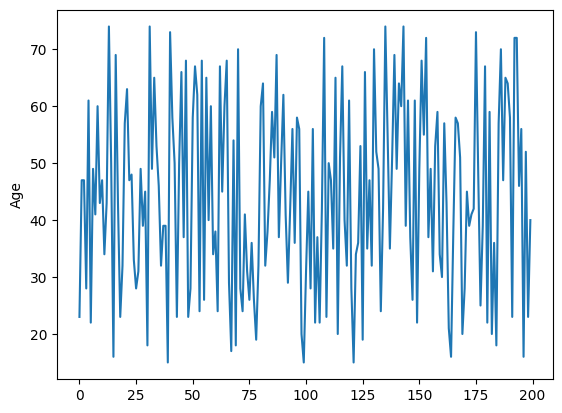

In [ ]:
# Let see distribution of age in data set
sns.lineplot(data["Age"])

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64


<Axes: xlabel='Drug', ylabel='count'>

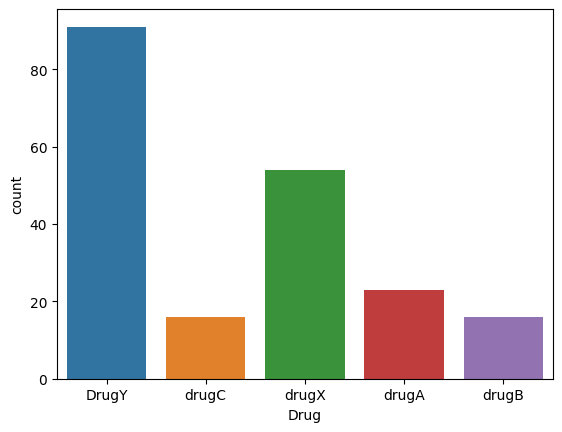

In [ ]:
# There is a lot of drugY
print(data.Drug.value_counts())
sns.countplot(x="Drug", data = data)

M    104
F     96
Name: Sex, dtype: int64


<Axes: xlabel='Sex', ylabel='count'>

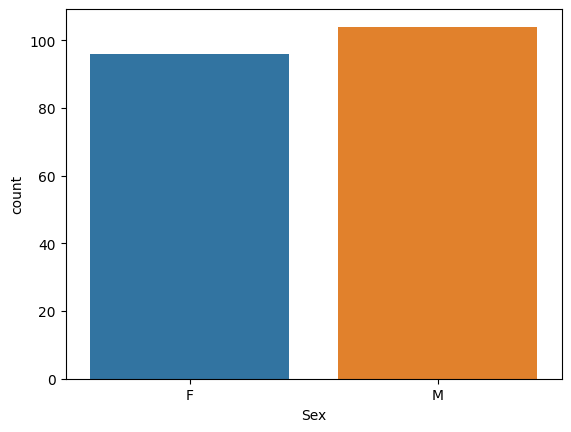

In [ ]:
#Let see how many male and female in this dataset
print(data.Sex.value_counts()) # => It seems balance
sns.countplot(x="Sex", data = data)

HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64


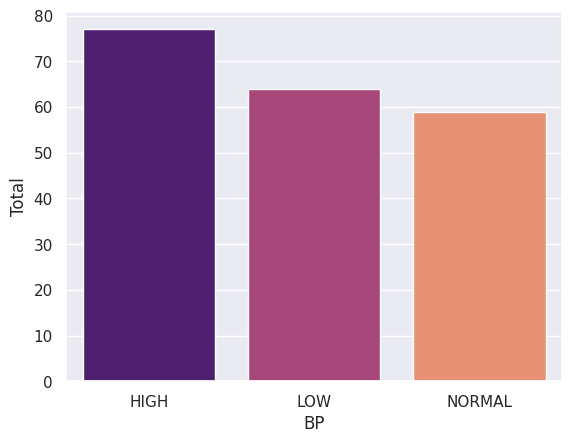

In [ ]:
#What about BP ?
print(data.BP.value_counts()) # it seems balance too

sns.set_theme(style="darkgrid")
sns.countplot(x="BP", data=data, palette="magma")
plt.xlabel('BP')
plt.ylabel('Total')
plt.show()


HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64


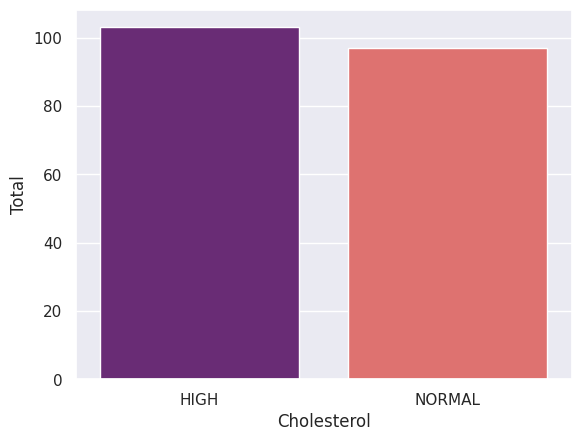

In [ ]:
#Cholesterol?
print(data.Cholesterol.value_counts()) # => Balanced too

sns.set_theme(style="darkgrid")
sns.countplot(x="Cholesterol", data=data, palette="magma")
plt.xlabel('Cholesterol')
plt.ylabel('Total')
plt.show()


The relationship between cols

<Axes: xlabel='Drug', ylabel='Age'>

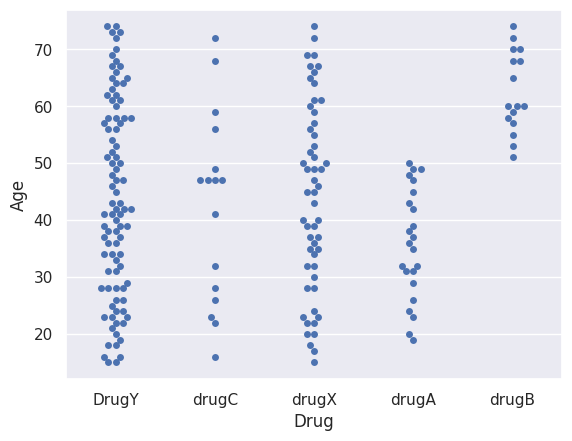

In [ ]:
sns.swarmplot(x="Drug", y="Age", data= data)

People in dataset use drug B with age above 50 and below 50 with drug A

How does gender impact drug choice?

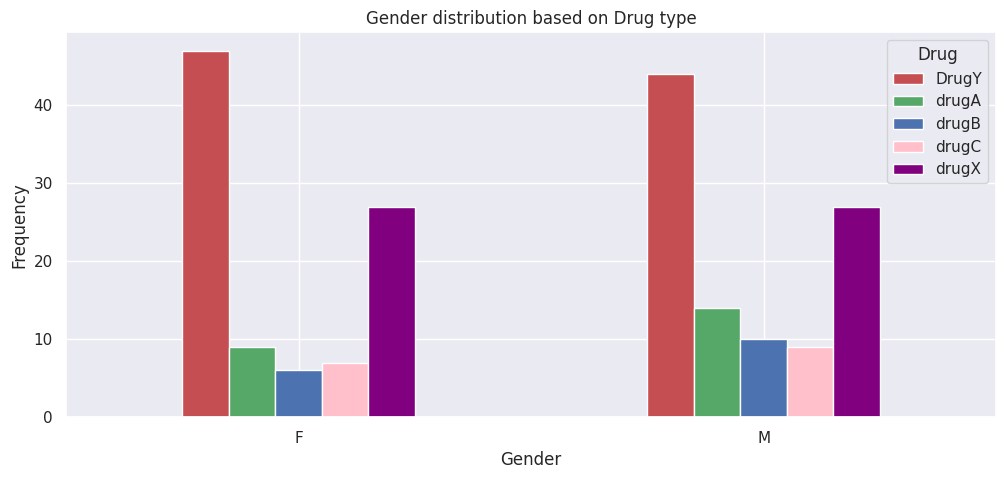

In [ ]:
# Gender and drugs? See what different
pd.crosstab(data.Sex,data.Drug).plot(kind="bar",figsize=(12,5),color=['r','g','b','#FFC0CB','#800080'])
plt.title('Gender distribution based on Drug type')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()
# There is a small different about drug A, B, C between 2 gender but it still seems balance, not a big problem for model to learn and predict

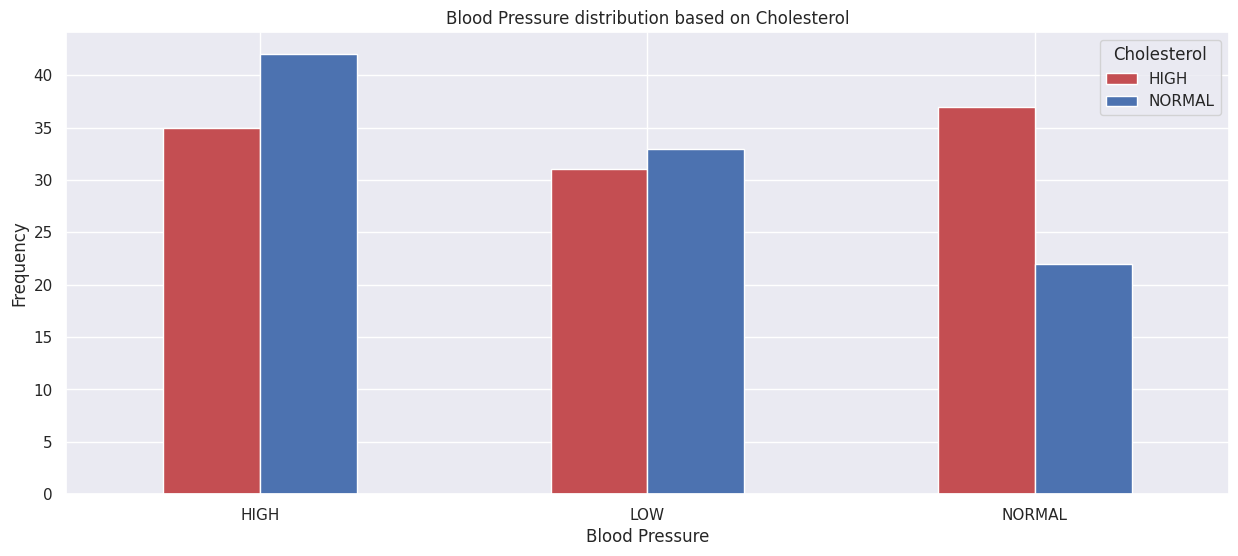

In [ ]:
#Relationship between BP and Cholesterol (!!!This is important)
pd.crosstab(data.BP, data.Cholesterol).plot(kind="bar",figsize=(15,6),color=['r','b'])
plt.title('Blood Pressure distribution based on Cholesterol')
plt.xlabel('Blood Pressure')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

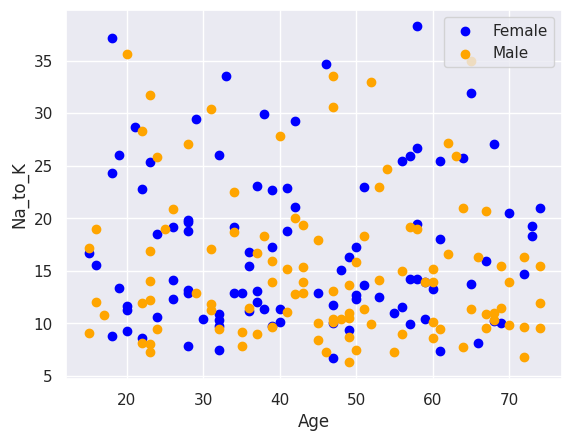

In [ ]:
#Na_to_K base on Age, gender
plt.scatter(x=data.Age[data.Sex=='F'], y=data.Na_to_K[(data.Sex=='F')], c="Blue")
plt.scatter(x=data.Age[data.Sex=='M'], y=data.Na_to_K[(data.Sex=='M')], c="Orange")
plt.legend(["Female", "Male"])
plt.xlabel("Age")
plt.ylabel("Na_to_K")
plt.show()
# In case of older, female always have Na to Ka index bigger than male

'\nPeople who take Drug C have the following attributes:\n- Low blood pressure.\n- High cholesterol.\n- Na to K <15\n'

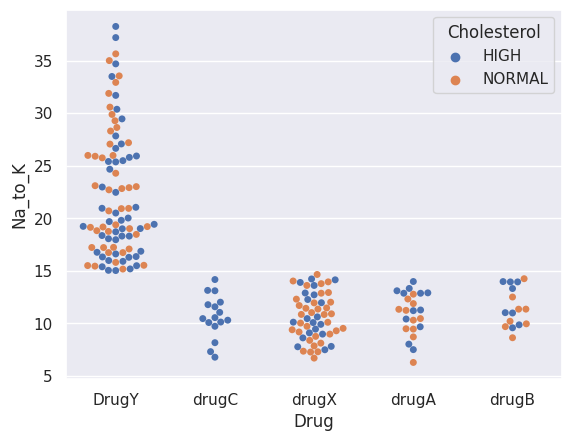

In [ ]:
# Relationship betwwen drug and na to k base on cholesterol
sns.swarmplot(x="Drug", y="Na_to_K", data=data, hue="Cholesterol")
"""
People who take Drug C have the following attributes:
- Low blood pressure.
- High cholesterol.
- Na to K <15
"""

#### Model

Divided into 7 age categories:
- Below 20
- 20 - 29
- 30 - 39
- 40 - 49
- 50 - 59
- 60 - 69
- Above 70

 The chemical ratio will be divided into 4 categories:

- Below 10
- 10 - 20
- 20 - 30
- Above 30

In [ ]:
def prepare_data(data):
  # Define age bins and categories
  age_bins = [0, 19, 29, 39, 49, 59, 69, 80]
  age_categories = ['<20s', '20s', '30s', '40s', '50s', '60s', '>60s']

  # Bin the 'Age' column and create a new 'Age_binned' column
  data['Age_binned'] = pd.cut(data['Age'], bins=age_bins, labels=age_categories)

  # Drop the original 'Age' column
  data.drop('Age', axis=1, inplace=True)

  # Define Na_to_K bins and categories
  nato_k_bins = [0, 9, 19, 29, 50]
  nato_k_categories = ['<10', '10-20', '20-30', '>30']

  # Bin the 'Na_to_K' column and create a new 'Na_to_K_binned' column
  data['Na_to_K_binned'] = pd.cut(data['Na_to_K'], bins=nato_k_bins, labels=nato_k_categories)

  # Drop the original 'Na_to_K' column
  data.drop('Na_to_K', axis=1, inplace=True)
  return data

In [ ]:
pre_process_data = prepare_data(data)
X = pre_process_data.drop(["Drug"], axis=1)
y = pre_process_data["Drug"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
# One-hot encoding for dataset
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

NameError: ignored

In [ ]:
# Because of number of 'DrugY' is more than other types of drugs, oversampling is carried out to avoid overfitting.
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [ ]:
"""
sns.set_theme(style="darkgrid")
sns.countplot(y=y_train, data=df_drug, palette="mako_r")
plt.ylabel('Drug Type')
plt.xlabel('Total')
plt.show()
"""

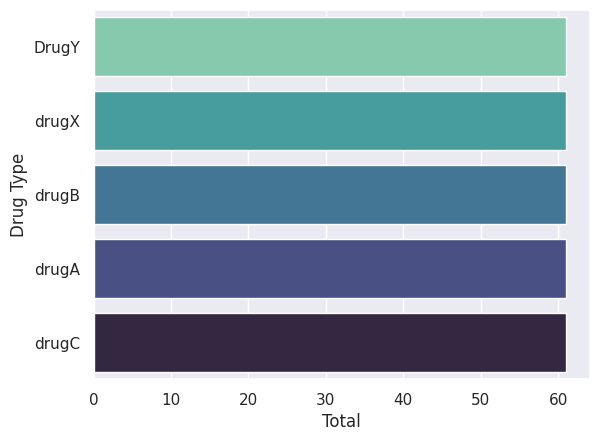

In [ ]:
sns.set_theme(style="darkgrid")
sns.countplot(y=y_train, data=data, palette="mako_r")
plt.ylabel('Drug Type')
plt.xlabel('Total')
plt.show()
# As can be seen, the distrubtion of drug type are now balanced.

In [ ]:
# Let's train
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
LRclassifier = LogisticRegression(solver='liblinear', max_iter=5000)
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.metrics import accuracy_score
LRAcc = accuracy_score(y_pred,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

       DrugY       0.91      0.70      0.79        30
       drugA       0.71      1.00      0.83         5
       drugB       0.75      1.00      0.86         3
       drugC       0.67      1.00      0.80         4
       drugX       0.80      0.89      0.84        18

    accuracy                           0.82        60
   macro avg       0.77      0.92      0.83        60
weighted avg       0.84      0.82      0.81        60

Logistic Regression accuracy is: 81.67%


In [ ]:
# Features of interest
features = ['Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
            'Cholesterol_HIGH', 'Cholesterol_NORMAL',
            'Age_binned_<20s', 'Age_binned_20s', 'Age_binned_30s',
            'Age_binned_40s', 'Age_binned_50s', 'Age_binned_60s', 'Age_binned_>60s',
            'Na_to_K_binned_<10', 'Na_to_K_binned_10-20', 'Na_to_K_binned_20-30', 'Na_to_K_binned_>30']

# Create a new DataFrame from X_test with the selected features
prediction = X_test[features].copy()

prediction['DrugType'] = y
# Add the 'DrugType' column
prediction['DrugType-Predict'] = LRclassifier.predict(X_test)

# Print the result
prediction


,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age_binned_<20s,Age_binned_20s,Age_binned_30s,Age_binned_40s,Age_binned_50s,Age_binned_60s,Age_binned_>60s,Na_to_K_binned_<10,Na_to_K_binned_10-20,Na_to_K_binned_20-30,Na_to_K_binned_>30,DrugType,DrugType-Predict
18,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,drugC,drugC
170,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,drugX,drugX
107,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,DrugY,DrugY
98,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,DrugY,DrugY
177,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,DrugY,DrugY
182,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,drugX,DrugY
5,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,drugX,drugX
146,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,drugX,drugX
12,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,DrugY,drugC
152,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,drugX,drugX


In [ ]:
def process_data(prediction):
  # Sex
  prediction['Sex_F'] = prediction['Sex_F'].replace([1, 0],['Female', 'Male'])

  #BP
  prediction['BP_HIGH'] = prediction['BP_HIGH'].replace([1, 0],['High',''])
  prediction['BP_LOW'] = prediction['BP_LOW'].replace([1, 0],['Low', ''])
  prediction['BP_NORMAL'] = prediction['BP_NORMAL'].replace([1, 0],['Normal', ''])

  prediction['BP_HIGH'] = np.where((prediction['BP_HIGH'] == ''), prediction['BP_LOW'], prediction['BP_HIGH'])
  prediction['BP_HIGH'] = np.where((prediction['BP_HIGH'] == ''), prediction['BP_NORMAL'], prediction['BP_HIGH'])

  #Cholestrol
  prediction['Cholesterol_HIGH'] = prediction['Cholesterol_HIGH'].replace([1, 0],['High', 'Normal'])


  # Age bins
  age_bins = ['<20s', '20s', '30s', '40s', '50s', '60s', '>60s']
  for bin in age_bins:
      prediction[f'Age_binned_{bin}'] = prediction[f'Age_binned_{bin}'].replace({1: bin, 0: ''})
      prediction['Age_binned_<20s'] = np.where((prediction['Age_binned_<20s'] == ''), prediction[f'Age_binned_{bin}'], prediction['Age_binned_<20s'])

  # Na to K bins
  na_k_bins = ['<10', '10-20', '20-30', '>30']
  for bin in na_k_bins:
      prediction[f'Na_to_K_binned_{bin}'] = prediction[f'Na_to_K_binned_{bin}'].replace({1: bin, 0: ''})
      prediction['Na_to_K_binned_<10'] = np.where((prediction['Na_to_K_binned_<10'] == ''), prediction[f'Na_to_K_binned_{bin}'], prediction['Na_to_K_binned_<10'])

  # Drop unnecessary columns
  columns_to_drop = ['Sex_M', 'BP_LOW', 'BP_NORMAL', 'Cholesterol_NORMAL', 'Age_binned_20s', 'Age_binned_30s',
                    'Age_binned_40s', 'Age_binned_50s', 'Age_binned_60s', 'Age_binned_>60s',
                    'Na_to_K_binned_10-20', 'Na_to_K_binned_20-30', 'Na_to_K_binned_>30']
  prediction = prediction.drop(columns=columns_to_drop, axis=1)
  prediction = prediction.rename(columns={'Cholesterol_HIGH': 'Cholesterol', 'Sex_F':'Sex', 'BP_HIGH':'Blood Pressure'})
  return prediction

In [ ]:
process_data(prediction)

,Sex,Blood Pressure,Cholesterol,Age_binned_<20s,Na_to_K_binned_<10,DrugType,DrugType-Predict
18,Male,Low,High,20s,<10,drugC,drugC
170,Female,Normal,High,20s,10-20,drugX,drugX
107,Male,Low,High,40s,20-30,DrugY,DrugY
98,Male,High,Normal,20s,>30,DrugY,DrugY
177,Male,Normal,High,20s,20-30,DrugY,DrugY
182,Female,Low,Normal,20s,10-20,drugX,DrugY
5,Female,Normal,High,20s,<10,drugX,drugX
146,Female,Low,Normal,30s,10-20,drugX,drugX
12,Male,Low,High,40s,10-20,DrugY,drugC
152,Male,Normal,Normal,50s,<10,drugX,drugX


In [ ]:
predict_data = {
    'Age': [12, 20, 31, 40, 21],
    'Sex': ['F', 'F', 'M', 'M', 'M'],
    'BP': ['HIGH','LOW','HIGH','LOW','NORMAL'],
    'Cholesterol': ['HIGH', 'HIGH', 'NORMAL', 'NORMAL', 'NORMAL'],
}
# Tạo DataFrame từ dữ liệu
data = pd.DataFrame(predict_data)
data['Na_to_K'] = np.random.uniform(5, 30, len(data))
data

,Age,Sex,BP,Cholesterol,Na_to_K
0,12,F,HIGH,HIGH,18.741780
1,20,F,LOW,HIGH,7.984891
2,31,M,HIGH,NORMAL,20.175986
3,40,M,LOW,NORMAL,7.580259
4,21,M,NORMAL,NORMAL,12.509577


In [ ]:
predict_data = data
predict_data = prepare_data(predict_data)
predict_data

,Sex,BP,Cholesterol,Age_binned,Na_to_K_binned
0,F,HIGH,HIGH,<20s,20-30
1,F,LOW,HIGH,20s,20-30
2,M,HIGH,NORMAL,30s,10-20
3,M,LOW,NORMAL,40s,<10
4,M,NORMAL,NORMAL,20s,<10


In [ ]:
# One hot encoding for data
predict_data = pd.get_dummies(predict_data)
predict_data

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age_binned_<20s,Age_binned_20s,Age_binned_30s,Age_binned_40s,Age_binned_50s,Age_binned_60s,Age_binned_>60s,Na_to_K_binned_<10,Na_to_K_binned_10-20,Na_to_K_binned_20-30,Na_to_K_binned_>30
0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0


In [ ]:
# Predict with traiend model
predictions = LRclassifier.predict(predict_data)

# ADd 'DrugType-Predict' into DataFrame
data['DrugType-Predict'] = predictions
data

,Sex,BP,Cholesterol,Age_binned,Na_to_K_binned,DrugType-Predict
0,F,HIGH,HIGH,<20s,20-30,DrugY
1,F,LOW,HIGH,20s,20-30,DrugY
2,M,HIGH,NORMAL,30s,10-20,drugA
3,M,LOW,NORMAL,40s,<10,drugX
4,M,NORMAL,NORMAL,20s,<10,drugX
